# Item Recommender
---
This document demonstrates how to recommend items for Style Lend renters. The recommendation is based on the renters'shopping history abd the similarities between all available items using the description text of items stored in stylelend.com database. The model also takes advantages of renters' size records, brand preferences, and cloth type preferences.

### Outline
---

1. [**Introduction**](#intro)
2. [**Tokenized Item Descriptions**](#tokens)

    - [Part-of-Speech](#part-of-speech)
    - [Word2vec](#word2vec)
    - [Description-Semantics](#cosine)      
<br>
3. [**Brand Co-occurence Network**](#brand)

    - [Network-of-Brands](#brand-networks)
    - [Brand-Features](#brand-features)
<br>
4. [**Recommender**](#recommender)

    - [Cosine-Similarity](#consine)
    - [Rank Metrics](#rank)
    - [Validation](#validation) 
    
    
### Implementation Details
-----
Most of the functions, algorithms, and models used in this notebook have been wrapped in the module /script/recommender.py. This notebook is served for demonstration and explanation.

<a id='intro'></a>
# Introduction

Sending a **cutomized** recommending email to users can increase returning users and their Lifetime Value!

To start, we notice that only **18%** of the renters shop more than twice on the website. The sparsity of data render it impossible to make recommendations based on users' shopping behavior similarities. 

Instead, we use the item similarity to recommend the similar items to the items that a renter's rented before. The shopping history serves as a start point for us to select proper brands, cloth types, and sizes for users to begin with. Then we select the top **N** items from our similarity scores to recommend.


<a id='tokens'></a>
# Tokenized Item Descriptions
----
Description of an item tells us a lot! 

- Whether a dress is **everyday** style or **night** stype?
- What's the color? Golden or pink?
- What is the fabric? Nylon or silk?

The semantic similarity between description definitedly tells a lot on how similar two items are.


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../script')
import recommender as rd

df = rd.load_item_data()
df['description'].head()

id
5820    These golden goose are an all time everyday we...
2302    One shoulder asymmetrical dress with a single ...
1361    Structured blue Acne dress can be worn belted ...
2598    BCBGMAXAZRIA Grey Ombre Bandage Skirt. Stretch...
1462    Very dark blue leather crossbody bag from Long...
Name: description, dtype: object

<a id='part-of-speech'></a>
### Part of Speech

Not every word in the description contributes to the **characteristic** of the item.

When we tokenize the description, we first remove the meaningless stop-words (using the list provided by **nltk** package), such as *he, is, at, which, and on*.

Second, we notice that neither *verb* (such as can, do, are) or *adv* (such as very, great, slightly) contribute much. We use the **part-of-speech** package to class words into nouns, verbs, adjectives, and adverbs. We only keep the nons and adjectives in tokens.

Here is the example on tokenized descriptions. Now the tokens mostly contain meaningful words!

In [2]:
# Example on using tokenizer
df = rd.load_item_data()
df = rd.description_tokenizer(df)
df.to_csv("../source_data/item_df_n_tokens.csv")
df[['description','tokens']].head(2)

,description,tokens
id,,
5820,These golden goose are an all time everyday we...,golden goose everyday wear little pop wardrobe
2302,One shoulder asymmetrical dress with a single ...,shoulder asymmetrical single strap zip closure...


In [42]:
df.loc[2302,'description']

"One shoulder asymmetrical dress with a single beaded strap, back zip closure. This dress has been shortened to fit 5'2 and under.\n\nSize: M \nComposition: 90% Rayon 9% Nylon 1% Elastane \n"

# co-occurence matrix

In [5]:
cm = pd.read_csv('../source_data/brand_matrix.csv',index_col=0)

In [33]:
cm['total'] = cm.sum()
cm = cm.sort_values(['total'],ascending=False)
cm.drop('total',axis=1)
cm = cm[cm.index.tolist()]
cm = cm.div(cm.sum())

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

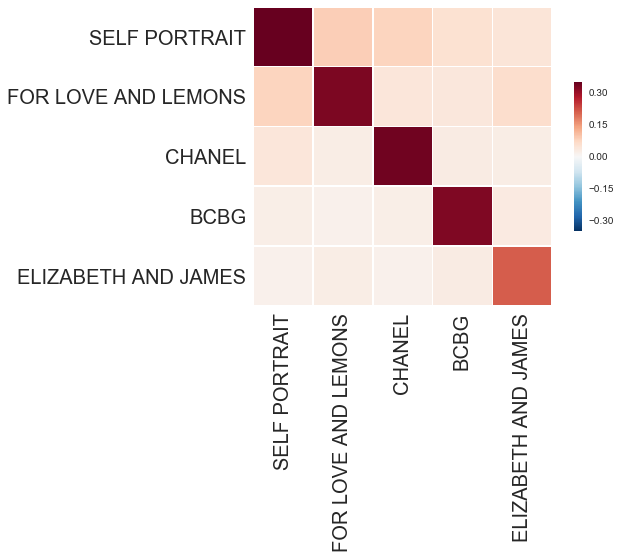

In [41]:
import seaborn as sns
sns.heatmap(cm.iloc[0:5,0:5], center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},cbar=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [11]:
cm[cm.index.tolist()]

,SELF PORTRAIT,FOR LOVE AND LEMONS,CHANEL,ELIZABETH AND JAMES,BCBG,ZIMMERMANN,LOVER,PARKER,ALICE + OLIVIA,STONE COLD FOX,...,GUCCI,JUST CAVALLI,ERIN FETHERSTON,HAUTE HIPPIE,ZAC POSEN,BLACK HALO,ROBERT RODRIGUEZ,LAUREN BY RALPH LAUREN,ONE BY NAVEN,IGIGI
SELF PORTRAIT,0.0,38.0,21.0,9.0,11.0,22.0,8.0,5.0,8.0,8.0,...,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
FOR LOVE AND LEMONS,38.0,0.0,11.0,12.0,8.0,18.0,8.0,6.0,7.0,8.0,...,1.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
CHANEL,21.0,11.0,0.0,5.0,6.0,8.0,6.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ELIZABETH AND JAMES,9.0,12.0,5.0,0.0,6.0,2.0,5.0,5.0,6.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
BCBG,11.0,8.0,6.0,6.0,0.0,2.0,3.0,5.0,4.0,2.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ZIMMERMANN,22.0,18.0,8.0,2.0,2.0,0.0,6.0,2.0,4.0,3.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
LOVER,8.0,8.0,6.0,5.0,3.0,6.0,0.0,5.0,2.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PARKER,5.0,6.0,4.0,5.0,5.0,2.0,5.0,0.0,4.0,3.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
ALICE + OLIVIA,8.0,7.0,5.0,6.0,4.0,4.0,2.0,4.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
STONE COLD FOX,8.0,8.0,5.0,5.0,2.0,3.0,3.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<a id='word2vec'></a>
### Word 2 Vec

Not every word in the description contributes to the **characteristic** of the item.

In [10]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format(
    '../source_data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
model.wv['english']

array([-0.13964844, -0.29296875,  0.08007812, -0.00927734, -0.1171875 ,
        0.12011719,  0.19824219,  0.06933594, -0.15332031,  0.07519531,
       -0.03491211, -0.34570312, -0.24511719, -0.16796875,  0.11474609,
        0.18847656,  0.06640625,  0.26757812,  0.14746094, -0.16113281,
        0.04370117,  0.3359375 ,  0.23632812,  0.04394531, -0.11572266,
        0.18652344, -0.14355469, -0.01135254, -0.00680542,  0.21679688,
        0.23242188,  0.2734375 , -0.24511719, -0.23144531, -0.10986328,
        0.28515625, -0.16992188,  0.3984375 ,  0.04516602,  0.04077148,
        0.13671875, -0.32226562,  0.12402344,  0.43554688,  0.22070312,
       -0.03491211, -0.04711914, -0.0402832 , -0.37890625,  0.13769531,
       -0.3203125 , -0.15722656,  0.33789062, -0.01306152, -0.24707031,
        0.07177734, -0.17089844, -0.20800781, -0.02905273, -0.32226562,
        0.1171875 , -0.10107422, -0.25390625, -0.25976562, -0.20507812,
       -0.34179688, -0.16308594,  0.08105469, -0.0390625 ,  0.21

In [45]:
df.head()

,description,item_type,size,brand,size_number,tokens
id,,,,,,
5820,These golden goose are an all time everyday we...,shoes,8,golden goose deluxe brand,8.0,golden goose everyday wear little pop wardrobe
2302,One shoulder asymmetrical dress with a single ...,dresses,6,Herve Leger,6.0,shoulder asymmetrical single strap zip closure...
1361,Structured blue Acne dress can be worn belted ...,dresses,4,Acne,4.0,blue acne loose avant silhouette shoulder inte...
2598,BCBGMAXAZRIA Grey Ombre Bandage Skirt. Stretch...,bottoms,4,BCBG,4.0,bandage stretchy fabric rayon nylon spandex
1462,Very dark blue leather crossbody bag from Long...,accessories,One-Size,Longchamp,NaN,dark blue leather bag


# EXAMPLE Codes

In [46]:
# example on using recommendations
cr = rd.customized_recommender()

select_item = df.index[3]
cr.filter_recommendation(select_item)
cr.recommend_items()

,description,item_type,size,brand,size_number,tokens
id,,,,,,
2598,BCBGMAXAZRIA Grey Ombre Bandage Skirt. Stretch...,bottoms,4,BCBG,4.0,bandage stretchy fabric rayon nylon spandex
2597,BCBGMAXAZRIA White Bandage Skirt. Size Small. ...,bottoms,4,BCBG,4.0,white bandage small stretchy fabric rayon nylo...
6931,This cute BCBGMAXAZRIA White Denim Skirt will ...,bottoms,4,BCBG,4.0,cute white denim great front back pocket cotto...
6880,Leather fringe belt.,accessories,One-Size,BCBG,NaN,leather fringe belt
5796,Beautiful statement necklace. Wore it once to ...,accessories,One-Size,BCBG,NaN,beautiful statement necklace brother hate unus...


In [3]:
# Example on using brand_similarity to save brand_similarity
bs = rd.brand_similarity()
brand_matrix = bs.brand_cooccur_matrix(thres=5)
brand_matrix.to_csv("../source_data/brand_matrix.csv")

../script/recommender.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  my_data['brand_code'] = le.transform(my_data['brand'])


In [6]:
# Exmaple on brand network analysis
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

G = nx.from_numpy_matrix()
pos=nx.circular_layout(G) 

nx.draw(G, pos=pos, node_size=13)

labels={}

for i in range(n):
    labels[i] = le.classes_[i]
    
nx.draw_networkx_labels(G,pos,labels,font_size=10,color='r')

NameError: name 'A' is not defined